In [4]:
!pip install kagglehub scikit-learn xgboost seaborn

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [5]:
path = kagglehub.dataset_download("aagambshah/lung-cancer-dataset")
df = pd.read_csv(f"{path}/survey lung cancer.csv")
df.columns = df.columns.str.strip().str.replace(" ", "_").str.upper()

**Data Preprocessing**

In [6]:
# Converting categorical Yes/No columns to binary
binary_cols = df.columns[df.nunique() == 2]
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   GENDER                 309 non-null    int64
 1   AGE                    309 non-null    int64
 2   SMOKING                309 non-null    int64
 3   YELLOW_FINGERS         309 non-null    int64
 4   ANXIETY                309 non-null    int64
 5   PEER_PRESSURE          309 non-null    int64
 6   CHRONIC_DISEASE        309 non-null    int64
 7   FATIGUE                309 non-null    int64
 8   ALLERGY                309 non-null    int64
 9   WHEEZING               309 non-null    int64
 10  ALCOHOL_CONSUMING      309 non-null    int64
 11  COUGHING               309 non-null    int64
 12  SHORTNESS_OF_BREATH    309 non-null    int64
 13  SWALLOWING_DIFFICULTY  309 non-null    int64
 14  CHEST_PAIN             309 non-null    int64
 15  LUNG_CANCER            309 non-null    i

**Exploratory Data Analysis**

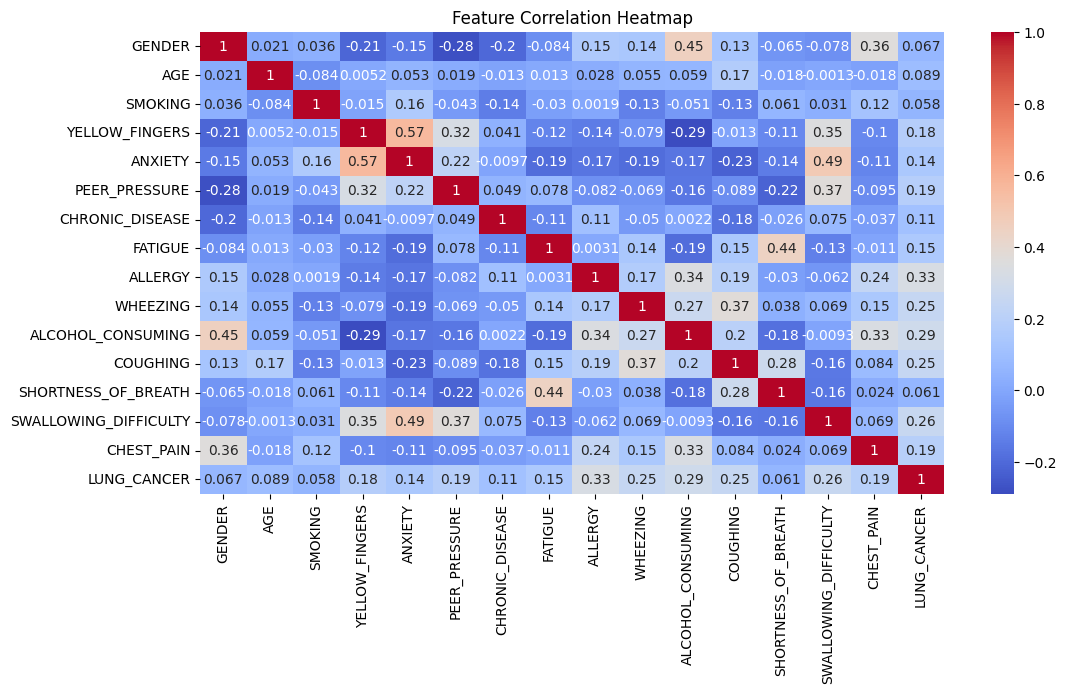

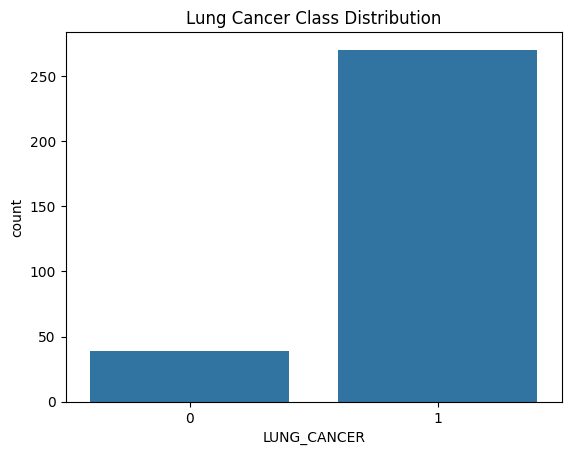

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

sns.countplot(x='LUNG_CANCER', data=df)
plt.title("Lung Cancer Class Distribution")
plt.show()


**Making Train-Test Split as well as feature Scaling**

In [8]:
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Model Building**

In [9]:
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Combining using Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', rf), ('xgb', xgb)
], voting='soft')

voting_clf.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:24:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

**Evaluation**

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.98      0.98      0.98        60

    accuracy                           0.97        62
   macro avg       0.74      0.74      0.74        62
weighted avg       0.97      0.97      0.97        62



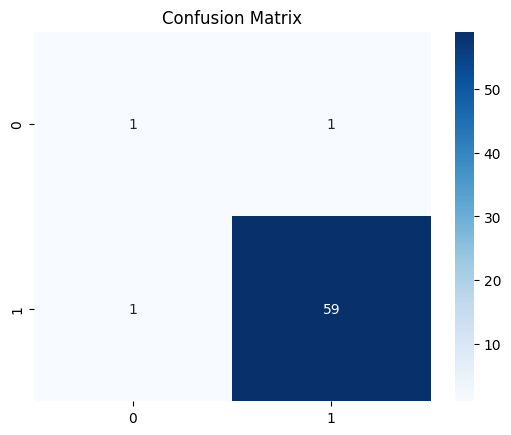

ROC AUC: 0.95


In [10]:
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

y_prob = voting_clf.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))

**Feature Importance**

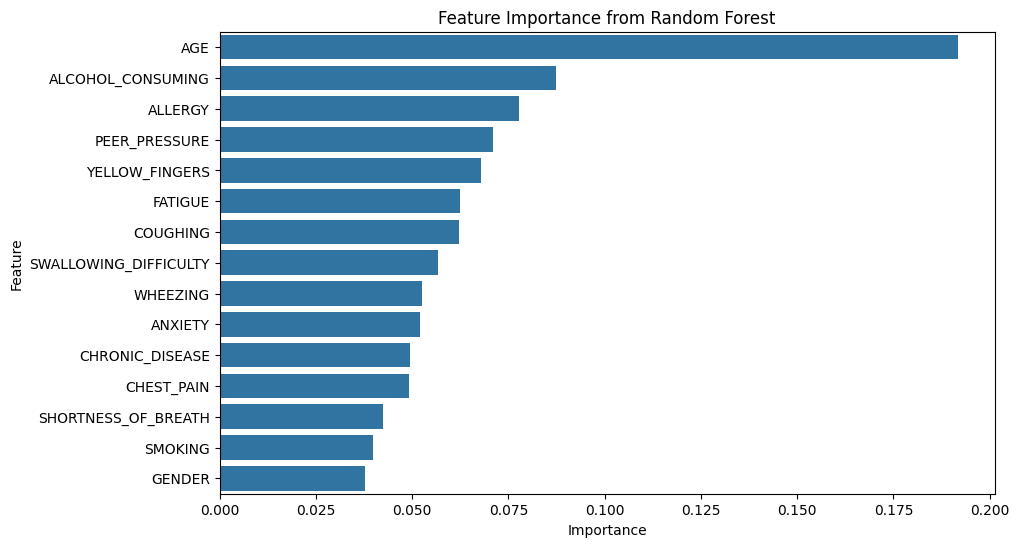

In [12]:
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feat_names = X.columns

feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance from Random Forest")
plt.show()